In [1]:
import pandas as pd
import pyBigWig
import actc_seq
import tqdm
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from collections import Counter
from pylab import rcParams
from itertools import product

In [2]:
# ess gene
ess_noness = pd.read_csv('../../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
# dhs

dhs_path = '../../Data/DHS/'
DHS_combined = pd.read_csv(dhs_path+'DHS_PeakOverlap.csv')

In [3]:
InhouseEssDHS = DHS_combined[(DHS_combined.DataSet == 'InHouse') & (DHS_combined['Target Gene Symbol'].isin(EssGene))]
otherDHS = DHS_combined[~(DHS_combined.DataSet == 'InHouse')]
newDHS = pd.concat([InhouseEssDHS,otherDHS])

In [4]:
newDHS

,Target Gene Symbol,chromosome,sgRNA Context Sequence,sgRNA 'Cut' Position,condition,Domain,DataSet,orginal phenotype,overlap with peak,DHS
87088,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,A549,Kox1,InHouse,-0.398339,0,K562
87089,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,A549,Zim3,InHouse,-0.841793,0,K562
87090,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,HCT116,Zim3,InHouse,-0.992358,0,K562
87095,COQ2,chr4,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0,A549,Kox1,InHouse,0.044728,0,K562
87096,COQ2,chr4,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0,A549,Zim3,InHouse,-0.190308,0,K562
...,...,...,...,...,...,...,...,...,...,...
949269,WDR11,chr10,GGCTAGGACCTCTACTACAATGAATGGGAG,120855890.0,K562,Kox1,Gilbert,-0.039824,0,A549
949270,WDR11,chr10,GCTAGGACCTCTACTACAATGAATGGGAGA,120855891.0,K562,Kox1,Gilbert,-0.043985,0,A549
949271,WDR11,chr10,CAGTCTTTCATCAAGTCTGATGTAAGGTAT,120855971.0,K562,Kox1,Gilbert,0.009044,0,A549
949272,WDR11,chr10,TTTATGTAGGTCCAAGTTTCAGTCTGGTAT,120856094.0,K562,Kox1,Gilbert,-0.001048,0,A549


In [5]:
def perform_mannwhitney_tests(chrtest, gene_col, phenotype):
    results = []
    # Get unique values from the specified columns
    DHS_seq = chrtest['DHS'].unique()
    DataSet = chrtest['DataSet'].unique()
    Domain = chrtest['Domain'].unique()
    condition = chrtest['condition'].unique()

    # Iterate over the combinations of parameters
    for dhs in tqdm(DHS_seq):
        
        for data in tqdm(DataSet):
            if data == 'InHouse':
                alter = 'greater'
            elif data == 'Nunez':
                alter = 'greater'
            elif data == 'Gilbert':
                alter = 'less' 
            for krab in tqdm(Domain):
                for cell in tqdm(condition):
                    chrtest_subset = chrtest[(chrtest['DHS'] == dhs) & (chrtest['Domain'] == krab) & 
                                             (chrtest['DataSet'] == data) & (chrtest['condition'] == cell)]
                    for gene in chrtest_subset[gene_col].unique():
                        gene_sp = chrtest_subset[chrtest_subset[gene_col] == gene]
                        binary_col = 'overlap with peak'
                        if (sum(gene_sp[binary_col] == 1) >= 10) & (sum(gene_sp[binary_col] == 0) >= 10):
                            _, pval = mannwhitneyu(gene_sp[gene_sp[binary_col] == 0][phenotype], 
                                                   gene_sp[gene_sp[binary_col] == 1][phenotype], 
                                                   alternative=alter, method="asymptotic")
                            results.append({
                                'DHS': dhs,
                                'DataSet': data,
                                'Domain': krab,
                                'condition': cell,
                                'gene': gene,
                                'pval': pval
                            })
                        else:
                            print(f"{gene}: Sample size in overlap or non-overlap < 10")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [6]:
results_df = perform_mannwhitney_tests(newDHS, 'Target Gene Symbol', 'orginal phenotype')


  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.12it/s]

CEBPE: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.19it/s]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.61it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.87s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.28it/s]

CEBPE: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.33it/s]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.79it/s]


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]

 33%|███████████████                              | 1/3 [00:03<00:07,  3.56s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.29it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.34it/s]

MRPL35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.25s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.15it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.26it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.20it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]

 67%|██████████████████████████████               | 2/3 [00:06<00:03,  3.08s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.96it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.05it/s]


100

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.22it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.19it/s]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.85s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.28it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.27it/s]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.73it/s]


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]

 33%|███████████████                              | 1/3 [00:03<00:07,  3.60s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.14it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.85it/s]

MRPL35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
RPP30: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.37s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.22it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.96it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.03it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.44s/it]

 67%|██████████████████████████████               | 2/3 [00:06<00:03,  3.17s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.40it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.33it/s]


100

CEBPE: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.13it/s]

U2AF1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.25it/s]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.80s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.33it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.27it/s]


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]

 33%|███████████████                              | 1/3 [00:03<00:07,  3.53s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.40it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.38it/s]

MRPL35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
RPL7L1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.31it/s]


 50%|██████████████████████▌                      | 1/2 [00:02<00:02,  2.29s/it]

U2AF1: Sample size in overlap or non-overlap < 10





  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  6.25it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.13it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.07it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]

 67%|██████████████████████████████               | 2/3 [00:06<00:03,  3.10s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 33%|███████████████                              | 1/3 [00:00<00:00,  5.97it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  5.93it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.87it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.61it/s]


  0

In [7]:
results_df

,DHS,DataSet,Domain,condition,gene,pval
0,K562,InHouse,Kox1,A549,LARS2,9.784334e-01
1,K562,InHouse,Kox1,A549,COQ2,1.136056e-03
2,K562,InHouse,Kox1,A549,IGBP1,9.698429e-01
3,K562,InHouse,Kox1,A549,YEATS4,3.900793e-03
4,K562,InHouse,Kox1,A549,COPS3,4.000144e-01
...,...,...,...,...,...,...
2808,A549,Gilbert,Kox1,K562,TUBA1B,1.627943e-02
2809,A549,Gilbert,Kox1,K562,UGP2,3.419396e-08
2810,A549,Gilbert,Kox1,K562,VPS53,7.797763e-03
2811,A549,Gilbert,Kox1,K562,VPS54,5.752588e-11


In [8]:
out_path = '../../Data/DHS/Pval/'

results_df.to_csv(out_path+'DHS_Pval.csv', index = False)

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
out_path = '../../Data/DHS/Pval/'

results_df = pd.read_csv(out_path+'DHS_Pval.csv')
results_df[results_df.gene == 'LARS2']
#K562	Nunez	Kox1	K562 BCAS2
#K562	Nunez	Kox1	K562	COG3

,DHS,DataSet,Domain,condition,gene,pval
0,K562,InHouse,Kox1,A549,LARS2,0.978433
232,K562,InHouse,Kox1,HCT116,LARS2,0.664239
286,K562,InHouse,Zim3,A549,LARS2,0.978051
429,K562,InHouse,Zim3,HCT116,LARS2,0.775345
942,HCT116,InHouse,Kox1,A549,LARS2,0.286052
1173,HCT116,InHouse,Kox1,HCT116,LARS2,0.126858
1226,HCT116,InHouse,Zim3,A549,LARS2,0.430805
1368,HCT116,InHouse,Zim3,HCT116,LARS2,0.198876
1877,A549,InHouse,Kox1,A549,LARS2,0.634902
2108,A549,InHouse,Kox1,HCT116,LARS2,0.228726


In [9]:
# ess gene
ess_noness = pd.read_csv('../../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
# dhs

dhs_path = out_path = '../../Data/DHS/Pval/'

DHS_combined = pd.read_csv(dhs_path+'DHS_PeakOverlap.csv')

InhouseEssDHS = DHS_combined[(DHS_combined.DataSet == 'InHouse') & (DHS_combined['Target Gene Symbol'].isin(EssGene))]
otherDHS = DHS_combined[~(DHS_combined.DataSet == 'InHouse')]
newDHS = pd.concat([InhouseEssDHS,otherDHS])

In [10]:
single_genes = newDHS[(newDHS['Target Gene Symbol'].isin(['LARS2'])) &
      (newDHS['condition'] == 'A549') & (newDHS['DHS'] == 'A549') &
      (newDHS['Domain'] == 'Kox1') & (newDHS['DataSet'] == 'InHouse')].copy()

Text(0, 0.5, 'Phenotype Value')

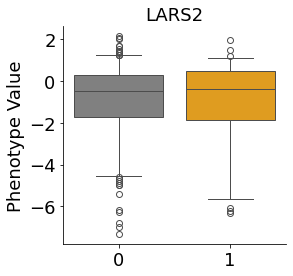

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(single_genes,
            x = 'overlap with peak', y='orginal phenotype', order=[0,1], 
                        palette=['grey','orange'], legend=False, 
            hue='overlap with peak' , whis = [5,95])
sns.despine()
plt.title('LARS2', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('')
plt.ylabel('Phenotype Value',fontsize=18)